In [1]:
import pandas as pd
import numpy as np
from itertools import product

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest

from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn import compose
from itertools import product
from sklearn.ensemble import RandomForestClassifier
import random

sns.set_theme()

/tmp/ipykernel_5354/1768671946.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
random.seed(123)

In [3]:
df_lung = pd.read_csv("./data/cancer patient data sets.csv")

# Functions for Attribute Inference

The function calculates the prior probabilities for one attribute column, returning them as a dictionary.

In [4]:
def calculate_priors(df, attribute):
  counts = df[attribute].value_counts()
  values = counts.index.values
  n = counts.sum()
  priors = (counts / n).values

  return dict(zip(values, priors))

This function employs the Naive Bayes theorem to calculate the combined prior probabilities of a set of attribute values.

In [5]:
def calculate_naive_priors(priors, values):
  return np.prod([priors[i][v] for (i, v) in enumerate(values)])

The `infer_attribute` function can perform two methods of attribute inference.

The first method is based on inferring the attribute solely on the probability of the model predicting the actual class of the sample multiplied by the prior probability of that valued of the attribute.

The other method leverages the conditional probability of the class being predicted (obtained from the confusion matrix of the model) multiplied by the prior of that attribute value as in the previous case. This method is calculated when the parameter `matrix` is provided to the function.

Both methods use a naive prior probability when multiple attributes are being inferred, assuming attribute independence. This assumption truly is naive, but sufficient.

In [6]:
def infer_attribute(sample, attrs, priors, model, class_idx, conf_matrix = None):

  combinations = list(product(*[p.keys() for p in priors]))
  imputed_sample = pd.DataFrame(np.repeat(sample.values, len(combinations),
                                          axis=0), columns=sample.columns)
  for (i, attr) in enumerate(attrs):
    imputed_sample[attr] = [c[i] for c in combinations]
  naive_priors = [calculate_naive_priors(priors, c) for c in combinations]

  predicted = model.predict_proba(imputed_sample)

  prob = []
  if conf_matrix is not None:
    idx_tmp_pred = [np.argmax(p) for p in predicted]
    prob = [conf_matrix[class_idx, pred] for pred in idx_tmp_pred]
  else:
    prob = list(map(lambda p: p[class_idx], predicted))

  assert len(prob) == len(naive_priors)
  r = np.multiply(prob, naive_priors)
  return list(combinations[np.argmax(r)])


In [7]:
def run_experiment(model, labels, df_prior, X_df, y_df, attrs, conf_matrix=None):
  assert(len(X_df) == len(y_df))
  priors = [calculate_priors(df_prior, attr) for attr in attrs]

  real = X_df[attrs]
  classes = [labels[label] for label in y_df]
  inferred = []
  for i in range (0, len(X_df)):
    X_curr = X_df[i:(i+1)]
    inferred.append(infer_attribute(X_curr, attrs, priors, model, classes[i],
                                    conf_matrix))

  return sum(np.array(real) == np.array(inferred)) / len(real)


# Data

## Data Cleaning

In [8]:
df_lung.drop(["index", "Patient Id"], axis="columns", inplace=True)

In [9]:
df_lung.shape

(1000, 24)

In [10]:
X, y = df_lung.drop("Level", axis="columns"), df_lung["Level"]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

In [12]:
train = pd.concat([X_train, y_train], axis="columns")
test = pd.concat([X_test, y_test], axis="columns")

## Exploratory Analysis

In [13]:
train.head()

,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,Obesity,...,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level
926,32,1,2,3,6,7,7,7,7,2,...,2,1,3,2,2,1,2,5,1,Low
916,33,1,6,7,7,7,7,6,7,7,...,4,4,5,6,5,5,4,6,5,High
775,25,2,4,5,6,5,5,4,6,7,...,8,7,9,2,1,4,6,7,2,High
26,38,2,2,1,5,3,2,3,2,4,...,6,7,2,5,8,1,3,2,3,Medium
776,18,2,6,8,7,7,7,6,7,7,...,3,2,4,1,4,2,4,2,3,High


In [14]:
train.dtypes

Age                          int64
Gender                       int64
Air Pollution                int64
Alcohol use                  int64
Dust Allergy                 int64
OccuPational Hazards         int64
Genetic Risk                 int64
chronic Lung Disease         int64
Balanced Diet                int64
Obesity                      int64
Smoking                      int64
Passive Smoker               int64
Chest Pain                   int64
Coughing of Blood            int64
Fatigue                      int64
Weight Loss                  int64
Shortness of Breath          int64
Wheezing                     int64
Swallowing Difficulty        int64
Clubbing of Finger Nails     int64
Frequent Cold                int64
Dry Cough                    int64
Snoring                      int64
Level                       object
dtype: object

In [15]:
train.describe()

,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,Obesity,...,Coughing of Blood,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring
count,800.000000,800.00000,800.000000,800.000000,800.00000,800.00000,800.000000,800.000000,800.000000,800.000000,...,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,36.967500,1.40875,3.782500,4.540000,5.14250,4.80750,4.546250,4.345000,4.462500,4.423750,...,4.831250,3.845000,3.841250,4.237500,3.775000,3.721250,3.902500,3.546250,3.813750,2.908750
std,12.052511,0.49191,2.032328,2.610923,1.98106,2.10499,2.135664,1.859515,2.129381,2.121866,...,2.420764,2.246616,2.219731,2.292414,2.022867,2.279813,2.413042,1.845839,2.033896,1.480934
min,14.000000,1.00000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,27.000000,1.00000,2.000000,2.000000,4.00000,3.00000,2.000000,3.000000,2.000000,3.000000,...,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
50%,35.000000,1.00000,3.000000,5.000000,6.00000,5.00000,5.000000,4.000000,4.000000,4.000000,...,4.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000
75%,45.000000,2.00000,6.000000,7.000000,7.00000,7.00000,7.000000,6.000000,7.000000,7.000000,...,7.000000,5.000000,6.000000,6.000000,5.000000,5.000000,5.000000,5.000000,6.000000,4.000000
max,73.000000,2.00000,8.000000,8.000000,8.00000,8.00000,7.000000,7.000000,7.000000,7.000000,...,9.000000,9.000000,8.000000,9.000000,8.000000,8.000000,9.000000,7.000000,7.000000,7.000000


In [16]:
train.nunique()

Age                         38
Gender                       2
Air Pollution                8
Alcohol use                  8
Dust Allergy                 8
OccuPational Hazards         8
Genetic Risk                 7
chronic Lung Disease         7
Balanced Diet                7
Obesity                      7
Smoking                      8
Passive Smoker               8
Chest Pain                   9
Coughing of Blood            9
Fatigue                      8
Weight Loss                  8
Shortness of Breath          8
Wheezing                     8
Swallowing Difficulty        8
Clubbing of Finger Nails     9
Frequent Cold                7
Dry Cough                    7
Snoring                      7
Level                        3
dtype: int64

There are no missing values in the dataset. The variables are categorical, ranking the patients symptoms on a scale of one to seven or nine, depending on the observed phenomenon.

In [17]:
train.mode().transpose()

,0
Age,35
Gender,1
Air Pollution,6
Alcohol use,2
Dust Allergy,7
OccuPational Hazards,7
Genetic Risk,7
chronic Lung Disease,6
Balanced Diet,7
Obesity,7


We observe the most common values per each feature, to get an idea for the baseline prediction later.

In [18]:
train['Level'].value_counts()

Level
High      283
Medium    265
Low       252
Name: count, dtype: int64

It is a multi-class classification problem. We are trying to classify the patient disease level into three classes. The dataset is well balanced.

In [19]:
levels = {
    "High": 2,
    "Low": 0,
    "Medium": 1
}
train = train.replace({'Level': levels})
test = test.replace({'Level': levels})

/tmp/ipykernel_5354/948129078.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train = train.replace({'Level': levels})
/tmp/ipykernel_5354/948129078.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test = test.replace({'Level': levels})


<Axes: >

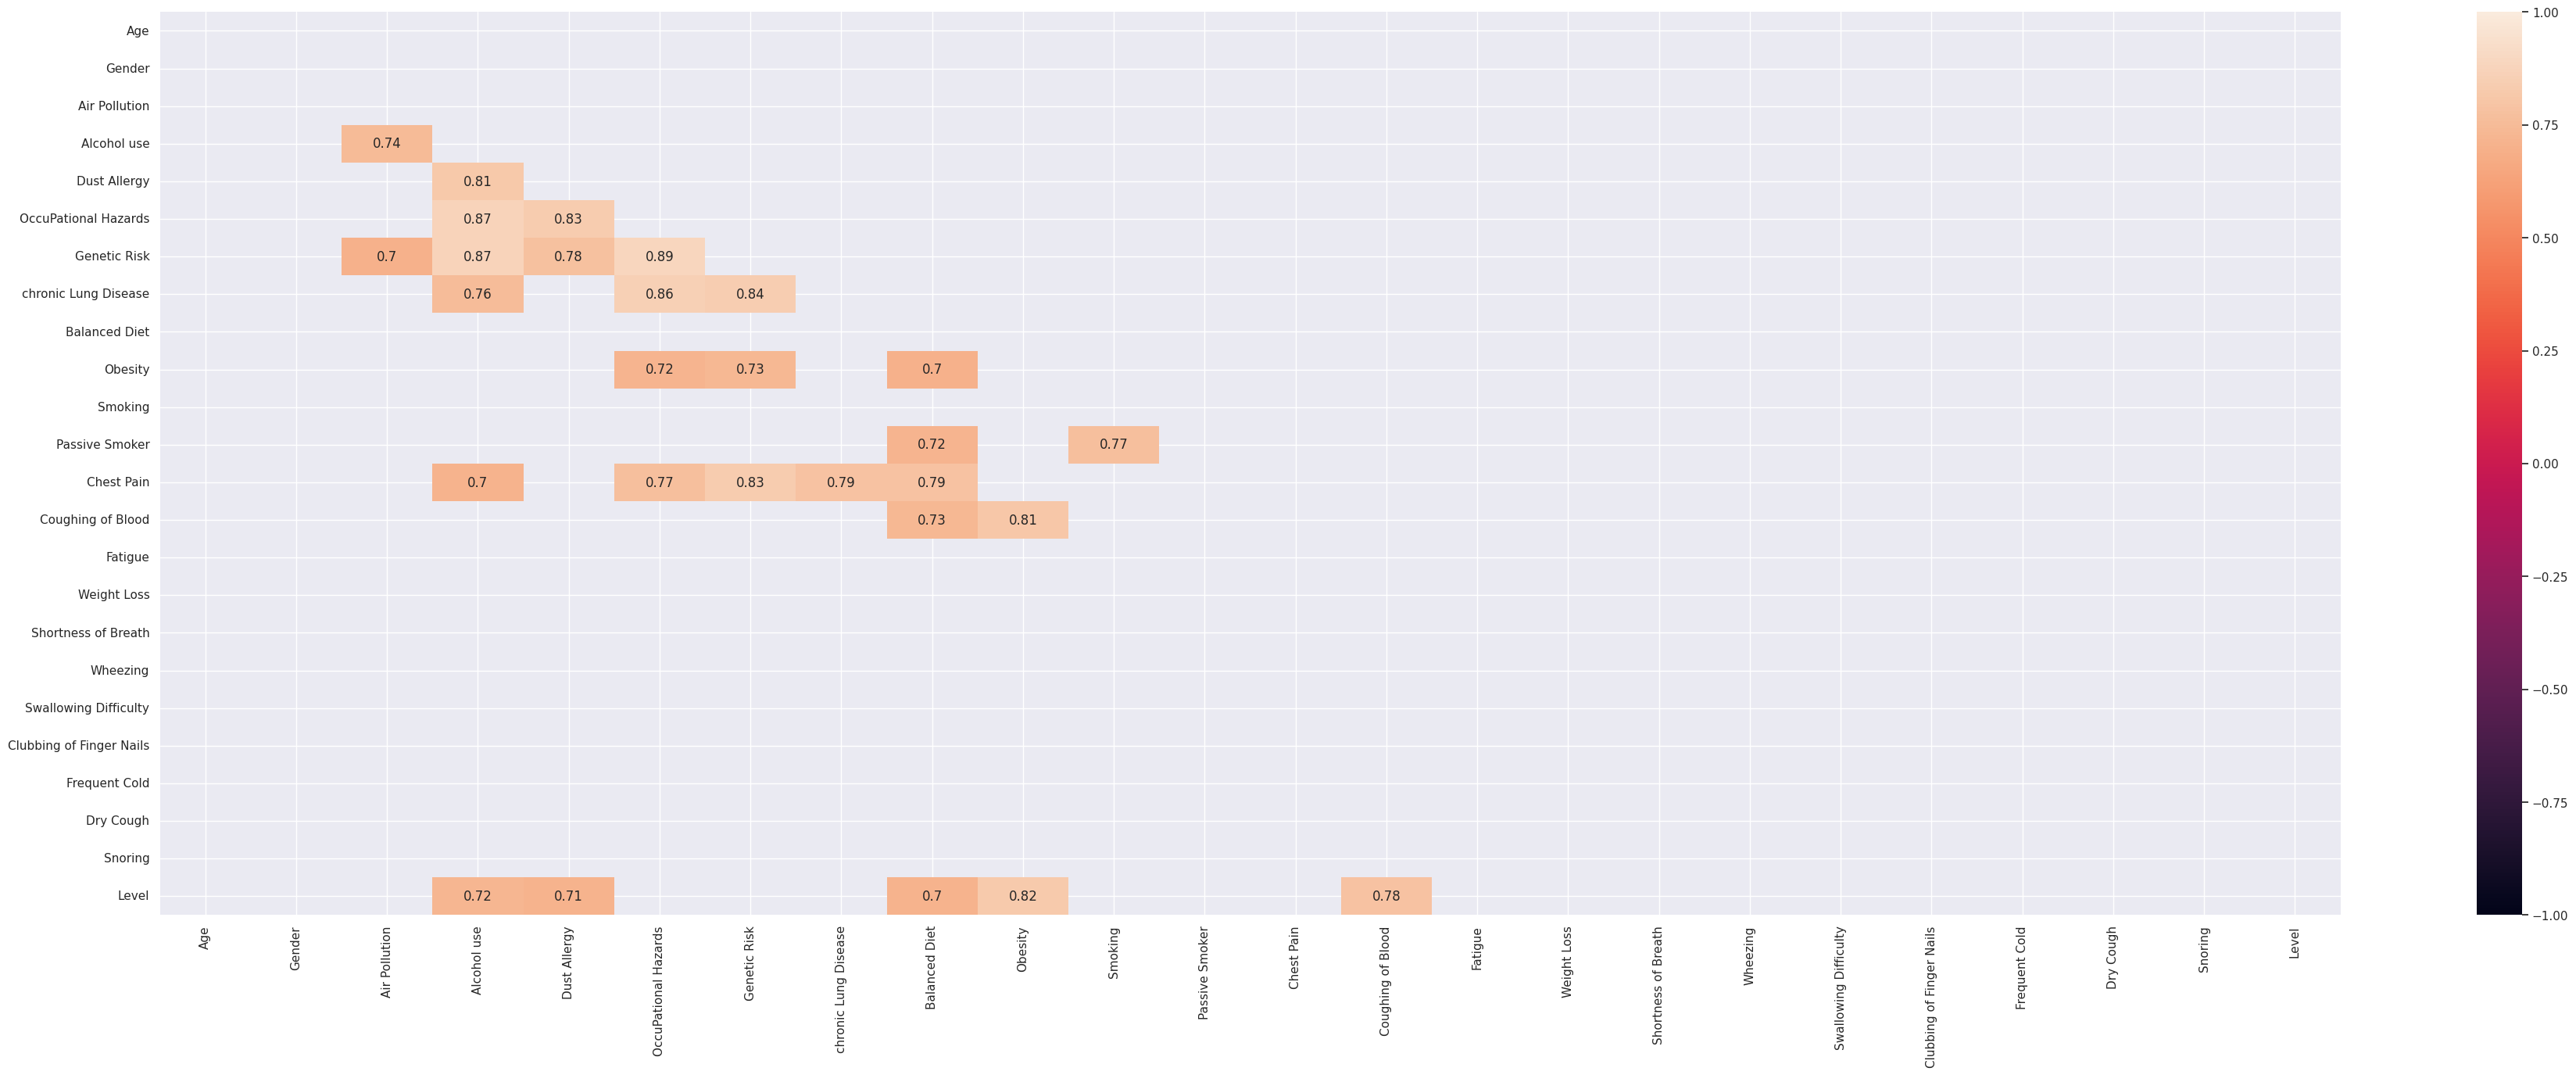

In [20]:
plt.figure(figsize=(45,15))
corr = train.corr(numeric_only=False)
corr = corr[abs(corr) > 0.7]
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, vmax=1, vmin=-1)

We observe that attributes like `Obesity`, `Coughing of Blood`, `Alcohol Use`, and `Dust Allergy` show relationship to the `Level` of disease of the patient.

# Baseline -- Most Frequent Value

We compute simple baseline for the most frequent value per attribute within the training set.

In [21]:
baseline_estiamates = {}

We are not considering the `Age` attribute

In [22]:
FEATURES = X_train.columns[1:]
print(FEATURES)

Index(['Gender', 'Air Pollution', 'Alcohol use', 'Dust Allergy',
       'OccuPational Hazards', 'Genetic Risk', 'chronic Lung Disease',
       'Balanced Diet', 'Obesity', 'Smoking', 'Passive Smoker', 'Chest Pain',
       'Coughing of Blood', 'Fatigue', 'Weight Loss', 'Shortness of Breath',
       'Wheezing', 'Swallowing Difficulty', 'Clubbing of Finger Nails',
       'Frequent Cold', 'Dry Cough', 'Snoring'],
      dtype='object')


In [23]:
for attr in FEATURES:
  most_frequent = X_train[attr].value_counts().idxmax()

  baseline_estiamates[attr] = most_frequent

print("Baseline estimates for each attribute: ")
print(baseline_estiamates)

Baseline estimates for each attribute: 
{'Gender': 1, 'Air Pollution': 6, 'Alcohol use': 2, 'Dust Allergy': 7, 'OccuPational Hazards': 7, 'Genetic Risk': 7, 'chronic Lung Disease': 6, 'Balanced Diet': 7, 'Obesity': 7, 'Smoking': 2, 'Passive Smoker': 2, 'Chest Pain': 7, 'Coughing of Blood': 7, 'Fatigue': 3, 'Weight Loss': 2, 'Shortness of Breath': 2, 'Wheezing': 2, 'Swallowing Difficulty': 1, 'Clubbing of Finger Nails': 2, 'Frequent Cold': 3, 'Dry Cough': 2, 'Snoring': 2}


# Logistic Regression Model

We create a pipeline to standardize the features and select the best ones, to reduce dimensionality.

In [24]:
model = make_pipeline(
    StandardScaler(),
    SelectKBest(),
    LogisticRegression()
)

## Feature Reduction

We iteratively asses the accuracy to find a good balance between this value and the model complexity (number of features).

In [25]:
for k in range(10, len(X_train.columns) + 1):
  model.set_params(selectkbest__k=k)
  model.fit(X_train, y_train)
  print(f"Acc at k={k}", accuracy_score(y_train, model.predict(X_train)))

Acc at k=10 0.83125
Acc at k=11 0.83375
Acc at k=12 0.90875
Acc at k=13 0.92
Acc at k=14 0.895
Acc at k=15 0.9925
Acc at k=16 1.0
Acc at k=17 1.0
Acc at k=18 1.0
Acc at k=19 1.0
Acc at k=20 1.0
Acc at k=21 1.0
Acc at k=22 1.0
Acc at k=23 1.0


In [26]:
K_FEATURES=15
model.set_params(selectkbest__k=K_FEATURES)
model.fit(X_train, y_train)
accuracy_score(y_train, model.predict(X_train))

0.9925

We want to reduce the number of features since we easily achieve accuracy of 1 even without the full set. Settling for 15 features offers a good reduction and just a minimal loss in accuracy.

In [27]:
skb = SelectKBest(k=K_FEATURES)
skb.fit(X_train, y_train)
FEATURES = skb.get_feature_names_out(X_train.columns)
print(FEATURES)

['Air Pollution' 'Alcohol use' 'Dust Allergy' 'OccuPational Hazards'
 'Genetic Risk' 'chronic Lung Disease' 'Balanced Diet' 'Obesity' 'Smoking'
 'Passive Smoker' 'Chest Pain' 'Coughing of Blood' 'Fatigue'
 'Shortness of Breath' 'Frequent Cold']


Above are the 15 features that will be used by the model.

In [28]:
accuracy_score(y_test, model.predict(X_test))

0.98

With this model we achieve a 98% accuracy on the test set, which is a very good result.

## Labels for predict_proba translation

In [29]:
sorted(["Low", "Medium", "High"])

['High', 'Low', 'Medium']

In [30]:
LABELS = {
    "High": 0,
    "Low": 1,
    "Medium": 2
}

## Experiments

In the following section we conduct experiments on the attribute inference. In total we have four different experiment settings and test two methods per setting.

In [31]:
y_pred = model.predict(X_train)
matrix = confusion_matrix(y_train, y_pred, normalize="pred",
                          labels=list(LABELS.keys()))

In [32]:
matrix

array([[1.        , 0.        , 0.        ],
       [0.        , 0.97674419, 0.        ],
       [0.        , 0.02325581, 1.        ]])

In [33]:
_, X_valid, _, y_valid = train_test_split(X_train, y_train,
                                          test_size=0.25, random_state=22)

In [34]:
X_valid.shape

(200, 23)

Dataframe to collect the final evaluation scores

In [35]:
df=pd.DataFrame(columns=['Attr', 'Value','Matrix','Train','Multiple Attributes'])

### 1. Single missing feature - Sample was in the training set.

In [36]:
for attr in FEATURES:
    val = run_experiment(model, LABELS, X_train,
                                    X_valid, y_valid, [attr])
    print(f"{attr}", val)

    new_row = pd.Series({'Attr': attr, 'Value': val[0], 'Matrix': 0, 'Train': 1,'Multiple Attributes': 0})
    df=pd.concat([df, new_row.to_frame().T], ignore_index=True)

Air Pollution [0.33]
Alcohol use [0.26]
Dust Allergy [0.42]
OccuPational Hazards [0.35]
Genetic Risk [0.405]
chronic Lung Disease [0.35]
Balanced Diet [0.355]
Obesity [0.41]


Smoking [0.195]
Passive Smoker [0.4]
Chest Pain [0.32]
Coughing of Blood [0.265]
Fatigue [0.31]
Shortness of Breath [0.245]
Frequent Cold [0.32]


In [37]:
for attr in FEATURES:
    val = run_experiment(model, LABELS, X_train,
                                    X_valid, y_valid, [attr], matrix)
    print(f"{attr}", val)
    new_row = pd.Series({'Attr': attr, 'Value': val[0], 'Matrix': 1, 'Train': 1, 'Multiple Attributes': 0})
    df=pd.concat([df, new_row.to_frame().T], ignore_index=True)

Air Pollution [0.32]
Alcohol use [0.21]
Dust Allergy [0.455]
OccuPational Hazards [0.35]
Genetic Risk [0.405]
chronic Lung Disease [0.35]
Balanced Diet [0.315]
Obesity [0.425]
Smoking [0.21]
Passive Smoker [0.39]
Chest Pain [0.325]
Coughing of Blood [0.285]
Fatigue [0.335]
Shortness of Breath [0.25]
Frequent Cold [0.325]


### 2. Single missing feature - Sample was not in the training set.

In [38]:
X_test.shape

(200, 23)

In [39]:
for attr in FEATURES:
    val = run_experiment(model, LABELS, train,
                                    X_test, y_test, [attr])
    print(f"{attr}", val)
    new_row = pd.Series({'Attr': attr, 'Value': val[0], 'Matrix': 0, 'Train': 0,'Multiple Attributes': 0})
    df=pd.concat([df, new_row.to_frame().T], ignore_index=True)

Air Pollution [0.38]
Alcohol use [0.275]
Dust Allergy [0.435]
OccuPational Hazards [0.405]
Genetic Risk [0.425]
chronic Lung Disease [0.39]
Balanced Diet [0.445]
Obesity [0.425]
Smoking [0.195]
Passive Smoker [0.475]
Chest Pain [0.335]
Coughing of Blood [0.23]
Fatigue [0.275]
Shortness of Breath [0.22]
Frequent Cold [0.225]


In [40]:
for attr in FEATURES:
    val = run_experiment(model, LABELS, train,
                                    X_test, y_test, [attr], matrix)
    print(f"{attr}", val)
    new_row = pd.Series({'Attr': attr, 'Value': val[0], 'Matrix': 1, 'Train': 0,'Multiple Attributes': 0})
    df=pd.concat([df, new_row.to_frame().T], ignore_index=True)

Air Pollution [0.37]
Alcohol use [0.225]
Dust Allergy [0.465]
OccuPational Hazards [0.405]
Genetic Risk [0.425]
chronic Lung Disease [0.39]
Balanced Diet [0.355]
Obesity [0.435]
Smoking [0.215]
Passive Smoker [0.44]
Chest Pain [0.32]
Coughing of Blood [0.255]
Fatigue [0.265]
Shortness of Breath [0.255]
Frequent Cold [0.25]


### 3. Multiple missing features - Sample was in the training set.


In [41]:
attrs3 = ["Alcohol use", "Dust Allergy", "Balanced Diet", "Obesity",
          "Coughing of Blood"]
values = []

## 28 224 combinations using the most correlated features

In [42]:
val = run_experiment(model, LABELS, X_train, X_valid, y_valid, attrs3)

for attr, v in zip(attrs3, val):
    values.append({'Attr': attr, 'Value': v, 'Matrix': 0, 'Train': 1, 'Multiple Attributes': 1})

In [43]:
val = run_experiment(model, LABELS, X_train, X_valid, y_valid, attrs3, matrix)

for attr, v in zip(attrs3, val):
    values.append({'Attr': attr, 'Value': v, 'Matrix': 1, 'Train': 1, 'Multiple Attributes': 1})

In [44]:
df = pd.concat([df, pd.DataFrame(values)], ignore_index=True)

### 4. Multiple missing features - Sample was not in the training set.


In [45]:
attrs4 = attrs3
values = []

In [46]:
val = run_experiment(model, LABELS, X_train, X_test, y_test, attrs4)

for attr, v in zip(attrs4, val):
    values.append({'Attr': attr, 'Value': v, 'Matrix': 0, 'Train': 0, 'Multiple Attributes': 1})

In [47]:
val = run_experiment(model, LABELS, X_train, X_test, y_test, attrs4, matrix)

for attr, v in zip(attrs4, val):
  values.append({'Attr': attr, 'Value': v, 'Matrix': 1, 'Train': 0, 'Multiple Attributes': 1})

In [48]:
df = pd.concat([df, pd.DataFrame(values)], ignore_index=True)

In [49]:
FEATURES=X_train.columns

In [50]:
df_lung

,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,Obesity,...,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level
0,33,1,2,4,5,4,3,2,2,4,...,3,4,2,2,3,1,2,3,4,Low
1,17,1,3,1,5,3,4,2,2,2,...,1,3,7,8,6,2,1,7,2,Medium
2,35,1,4,5,6,5,5,4,6,7,...,8,7,9,2,1,4,6,7,2,High
3,37,1,7,7,7,7,6,7,7,7,...,4,2,3,1,4,5,6,7,5,High
4,46,1,6,8,7,7,7,6,7,7,...,3,2,4,1,4,2,4,2,3,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,44,1,6,7,7,7,7,6,7,7,...,5,3,2,7,8,2,4,5,3,High
996,37,2,6,8,7,7,7,6,7,7,...,9,6,5,7,2,4,3,1,4,High
997,25,2,4,5,6,5,5,4,6,7,...,8,7,9,2,1,4,6,7,2,High
998,18,2,6,8,7,7,7,6,7,7,...,3,2,4,1,4,2,4,2,3,High


In [51]:
df

,Attr,Value,Matrix,Train,Multiple Attributes
0,Air Pollution,0.33,0,1,0
1,Alcohol use,0.26,0,1,0
2,Dust Allergy,0.42,0,1,0
3,OccuPational Hazards,0.35,0,1,0
4,Genetic Risk,0.405,0,1,0
...,...,...,...,...,...
75,Alcohol use,0.125,1,0,1
76,Dust Allergy,0.43,1,0,1
77,Balanced Diet,0.355,1,0,1
78,Obesity,0.415,1,0,1


In [ ]:
df['Model'] = "LogisticRegression"
df.to_csv("./results/df_LogisticRegression.csv")

### Evaluation

In [53]:
df_lr = pd.read_csv("./results/df_LogisticRegression.csv")

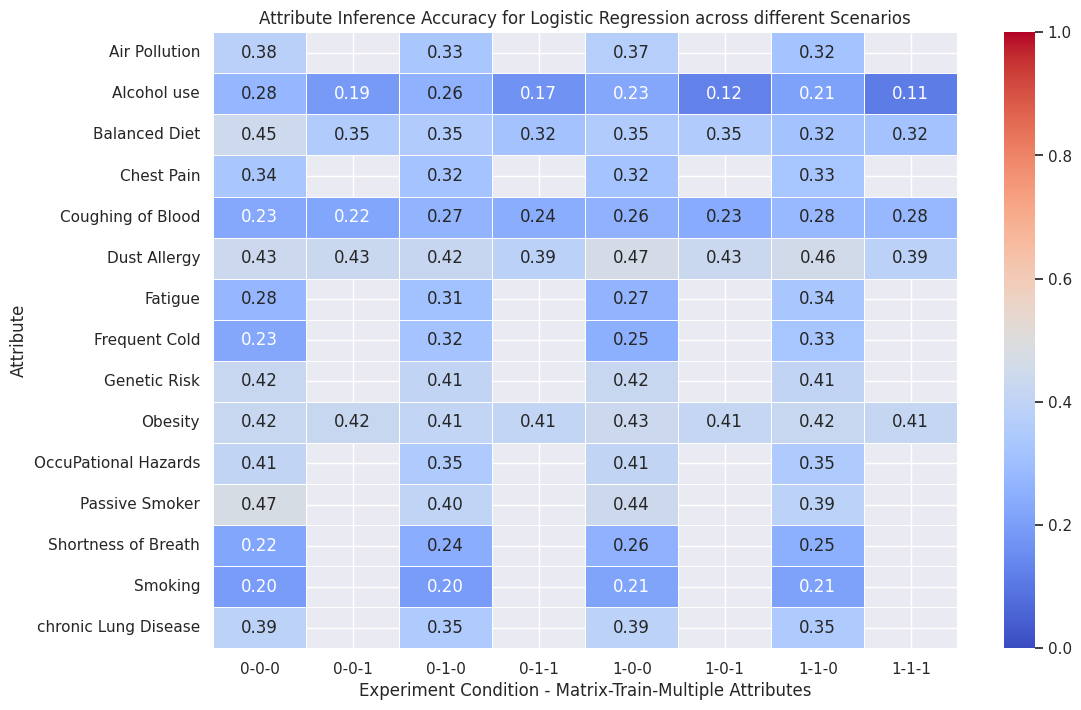

In [54]:
df_lr['Experiment'] = df_lr['Matrix'].astype(str) + '-' + df_lr['Train'].astype(str) + '-' + df_lr['Multiple Attributes'].astype(str)
p_df_lr = df_lr.pivot(index="Attr", columns="Experiment", values="Value").astype(float)

plt.figure(figsize=(12, 8))
sns.heatmap(p_df_lr, annot=True, fmt=".2f", cmap='coolwarm', vmin=0, vmax=1, linewidths=.4)
plt.title('Attribute Inference Accuracy for Logistic Regression across different Scenarios')
plt.ylabel('Attribute')
plt.xlabel('Experiment Condition - Matrix-Train-Multiple Attributes')
plt.show()

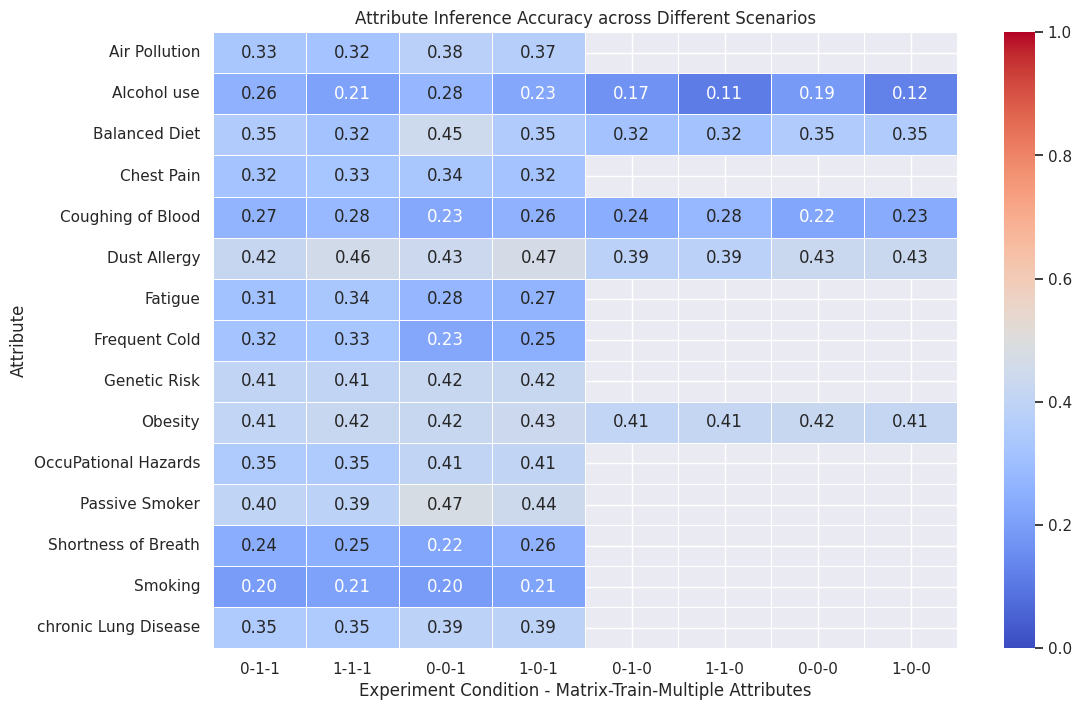

In [57]:
df = pd.read_csv("./results/df_LogisticRegression.csv")

values_order = [
    'Single - In Train - Without Matrix',
    'Single - In Train - With Matrix',
    'Single - Not In Train - Without Matrix',
    'Single - Not In Train - With Matrix',
    'Multiple - In Train - Without Matrix',
    'Multiple - In Train - With Matrix',
    'Multiple - Not In Train - Without Matrix',
    'Multiple - Not In Train - With Matrix'
]

df['Single_Multiple'] = df['Multiple Attributes'].apply(lambda x: 'Single' if x == 0 else 'Multiple')
df['In_Train'] = df['Train'].apply(lambda x: 'In Train' if x == 1 else 'Not In Train')
df['With_Matrix'] = df['Matrix'].apply(lambda x: 'With Matrix' if x == 1 else 'Without Matrix')
df['Condition'] = df['Single_Multiple'] + ' - ' + df['In_Train'] + ' - ' + df['With_Matrix']
df['Condition'] = df['Condition'].map(lambda x:values_order.index(x))
df_sorted = df.sort_values(by=['Condition'])
pivot_df = df_sorted.pivot(index="Attr", columns="Condition", values="Value").astype(float)

x_axis_labels = [
    '0-1-1',
    '1-1-1',
    '0-0-1',
    '1-0-1',
    '0-1-0',
    '1-1-0',
    '0-0-0',
    '1-0-0'
]

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap='coolwarm', vmin=0, vmax=1, linewidths=.5,
            xticklabels=x_axis_labels)
plt.title('Attribute Inference Accuracy across Different Scenarios')
plt.ylabel('Attribute')
plt.xlabel('Experiment Condition - Matrix-Train-Multiple Attributes')
plt.xticks()
plt.show()

# Random Forest Model

For the Random Forest Classifier we create and use two different models:
- `model_perfectFit` with no specified parameters, which will use a large number of trees and won't restrict the depth of the three leading to a perfect accuracy, therefore overfitting
- `model_underFit` this model includes restrictions on number leaf nodes and maximum depth, limiting the model's ability to fit to the trained data

In [58]:
model_perfectFit = make_pipeline(
    RandomForestClassifier()
)

In [59]:
model_perfectFit

Pipeline(steps=[('randomforestclassifier', RandomForestClassifier())])

In [60]:
model_perfectFit=model_perfectFit.fit(X_train, y_train)

In [61]:
model_underFit  = make_pipeline(
    RandomForestClassifier(max_leaf_nodes=3,max_depth=3))

In [62]:
model_underFit=model_underFit.fit(X_train, y_train)

## Performance

In [63]:
print(accuracy_score(y_train,model_perfectFit.predict(X_train)))
print(accuracy_score(y_train,model_underFit.predict(X_train)))

1.0
0.89


In [64]:
print(accuracy_score(y_test,model_perfectFit.predict(X_test)))
print(accuracy_score(y_test,model_underFit.predict(X_test)))

1.0
0.885


The best parameters from grid search are : {'mlpclassifier__activation': 'relu',
 'mlpclassifier__alpha': 0.0001,
 'mlpclassifier__hidden_layer_sizes': (7, 5),
 'mlpclassifier__solver': 'lbfgs'} -> but with no convergence

## Experiments

### Overfitting Scenario

Since we achieve accuracy = 100% in training and test set, the attribute with the prediction matrix only considers the priors.

In [65]:
df=pd.DataFrame(columns=['Attr', 'Value','Matrix','Train','Fit'])

In [66]:
FEATURES = X_train.columns[1:]

#### Single missing feature -  Sample was in training set

In [67]:
for attr in FEATURES:
  val=run_experiment(model_perfectFit, LABELS, X_train,
                                    X_valid, y_valid, [attr])
  print(f"{attr}", val)
  new_row = pd.Series({'Attr': attr, 'Value': val[0], 'Matrix': 0, 'Train': 1,'Fit':'perfect'})
  df=pd.concat([df, new_row.to_frame().T], ignore_index=True)

Gender [0.58]
Air Pollution [0.31]
Alcohol use [0.385]
Dust Allergy [0.385]
OccuPational Hazards [0.34]
Genetic Risk [0.3]
chronic Lung Disease [0.285]
Balanced Diet [0.355]
Obesity [0.345]
Smoking [0.25]
Passive Smoker [0.27]
Chest Pain [0.315]
Coughing of Blood [0.36]
Fatigue [0.285]
Weight Loss [0.32]
Shortness of Breath [0.215]
Wheezing [0.375]
Swallowing Difficulty [0.175]
Clubbing of Finger Nails [0.27]
Frequent Cold [0.235]
Dry Cough [0.275]
Snoring [0.265]


In [68]:
pd.DataFrame(df)

,Attr,Value,Matrix,Train,Fit
0,Gender,0.58,0,1,perfect
1,Air Pollution,0.31,0,1,perfect
2,Alcohol use,0.385,0,1,perfect
3,Dust Allergy,0.385,0,1,perfect
4,OccuPational Hazards,0.34,0,1,perfect
5,Genetic Risk,0.3,0,1,perfect
6,chronic Lung Disease,0.285,0,1,perfect
7,Balanced Diet,0.355,0,1,perfect
8,Obesity,0.345,0,1,perfect
9,Smoking,0.25,0,1,perfect


In [69]:
y_pred_perfect=model_perfectFit.predict(X_train)

In [70]:
LABELS.keys

<function dict.keys>

In [71]:
matrix_perfect= confusion_matrix(y_train, y_pred_perfect,normalize="pred", labels=list(LABELS.keys()))

In [72]:
for attr in FEATURES:
  val=run_experiment(model_perfectFit, LABELS, X_train,
                                    X_valid, y_valid, [attr],conf_matrix=matrix_perfect)
  print(f"{attr}", val)
  new_row = pd.Series({'Attr': attr, 'Value': val[0], 'Matrix': 1, 'Train': 1,'Fit':'perfect'})
  df=pd.concat([df, new_row.to_frame().T], ignore_index=True)

Gender [0.58]
Air Pollution [0.31]
Alcohol use [0.21]
Dust Allergy [0.385]
OccuPational Hazards [0.34]
Genetic Risk [0.3]
chronic Lung Disease [0.285]
Balanced Diet [0.315]
Obesity [0.345]
Smoking [0.205]
Passive Smoker [0.24]
Chest Pain [0.315]
Coughing of Blood [0.195]
Fatigue [0.26]
Weight Loss [0.32]
Shortness of Breath [0.215]
Wheezing [0.27]
Swallowing Difficulty [0.175]
Clubbing of Finger Nails [0.26]
Frequent Cold [0.235]
Dry Cough [0.275]
Snoring [0.265]


#### Single missing feature -  Sample was not in training set

In [73]:
for attr in FEATURES:
  val=run_experiment(model_perfectFit, LABELS, X_train,
                                    X_test, y_test, [attr])
  print(f"{attr}", val)
  new_row = pd.Series({'Attr': attr, 'Value': val[0], 'Matrix': 0, 'Train': 0,'Fit':'perfect'})
  df=pd.concat([df, new_row.to_frame().T], ignore_index=True)

Gender [0.625]
Air Pollution [0.365]
Alcohol use [0.425]
Dust Allergy [0.43]
OccuPational Hazards [0.4]
Genetic Risk [0.345]
chronic Lung Disease [0.345]
Balanced Diet [0.395]
Obesity [0.39]
Smoking [0.285]
Passive Smoker [0.325]
Chest Pain [0.315]
Coughing of Blood [0.36]
Fatigue [0.19]
Weight Loss [0.26]
Shortness of Breath [0.23]
Wheezing [0.325]
Swallowing Difficulty [0.185]
Clubbing of Finger Nails [0.245]
Frequent Cold [0.185]
Dry Cough [0.24]
Snoring [0.275]


In [74]:
for attr in FEATURES:
  val=run_experiment(model_perfectFit, LABELS, X_train,
                                    X_test, y_test, [attr],conf_matrix=matrix_perfect)
  print(f"{attr}", val)
  new_row = pd.Series({'Attr': attr, 'Value': val[0], 'Matrix': 1, 'Train': 0,'Fit':'perfect'})
  df=pd.concat([df, new_row.to_frame().T], ignore_index=True)

Gender [0.625]
Air Pollution [0.365]
Alcohol use [0.225]
Dust Allergy [0.43]
OccuPational Hazards [0.4]
Genetic Risk [0.345]
chronic Lung Disease [0.345]
Balanced Diet [0.355]
Obesity [0.39]
Smoking [0.235]
Passive Smoker [0.305]
Chest Pain [0.315]
Coughing of Blood [0.2]
Fatigue [0.17]
Weight Loss [0.26]
Shortness of Breath [0.23]
Wheezing [0.21]
Swallowing Difficulty [0.185]
Clubbing of Finger Nails [0.24]
Frequent Cold [0.185]
Dry Cough [0.24]
Snoring [0.275]


### Reducing Overfitting Scenario

In [75]:
y_pred_under=model_underFit.predict(X_train)

In [76]:
matrix_underFit= confusion_matrix(y_train, y_pred_under, normalize="pred", labels=list(LABELS.keys()))

#### Single missing feature -  Sample was in training set

In [77]:
for attr in FEATURES:
  val=run_experiment(model_underFit, LABELS, X_train,
                                    X_valid, y_valid, [attr])
  print(f"{attr}", val)
  new_row = pd.Series({'Attr': attr, 'Value': val[0], 'Matrix': 0, 'Train': 1,'Fit':'under'})
  df=pd.concat([df, new_row.to_frame().T], ignore_index=True)

Gender [0.58]
Air Pollution [0.31]
Alcohol use [0.36]
Dust Allergy [0.385]
OccuPational Hazards [0.34]
Genetic Risk [0.3]
chronic Lung Disease [0.285]
Balanced Diet [0.3]
Obesity [0.345]
Smoking [0.215]
Passive Smoker [0.24]
Chest Pain [0.315]
Coughing of Blood [0.32]
Fatigue [0.26]
Weight Loss [0.32]
Shortness of Breath [0.215]
Wheezing [0.27]
Swallowing Difficulty [0.175]
Clubbing of Finger Nails [0.26]
Frequent Cold [0.235]
Dry Cough [0.275]
Snoring [0.265]


In [78]:
for attr in FEATURES:
  val=run_experiment(model_perfectFit, LABELS, X_train,
                                    X_valid, y_valid, [attr],conf_matrix=matrix_underFit)
  print(f"{attr}", val)
  new_row = pd.Series({'Attr': attr, 'Value': val[0], 'Matrix': 1, 'Train': 1,'Fit':'under'})
  df=pd.concat([df, new_row.to_frame().T], ignore_index=True)

Gender [0.58]
Air Pollution [0.31]
Alcohol use [0.21]
Dust Allergy [0.385]
OccuPational Hazards [0.34]
Genetic Risk [0.3]
chronic Lung Disease [0.285]
Balanced Diet [0.315]
Obesity [0.345]
Smoking [0.205]
Passive Smoker [0.24]
Chest Pain [0.315]
Coughing of Blood [0.195]
Fatigue [0.26]
Weight Loss [0.32]
Shortness of Breath [0.215]
Wheezing [0.27]
Swallowing Difficulty [0.175]
Clubbing of Finger Nails [0.26]
Frequent Cold [0.235]
Dry Cough [0.275]
Snoring [0.265]


#### Single missing feature -  Sample was not in training set

In [79]:
for attr in FEATURES:
  val= run_experiment(model_underFit, LABELS, X_train,
                                    X_test, y_test, [attr])
  print(f"{attr}", val)
  new_row = pd.Series({'Attr': attr, 'Value': val[0], 'Matrix': 0, 'Train': 0,'Fit':'under'})
  df=pd.concat([df, new_row.to_frame().T], ignore_index=True)

Gender [0.625]
Air Pollution [0.365]
Alcohol use [0.385]
Dust Allergy [0.43]
OccuPational Hazards [0.4]
Genetic Risk [0.345]
chronic Lung Disease [0.345]
Balanced Diet [0.345]
Obesity [0.39]
Smoking [0.26]
Passive Smoker [0.305]
Chest Pain [0.315]
Coughing of Blood [0.33]
Fatigue [0.17]
Weight Loss [0.26]
Shortness of Breath [0.23]
Wheezing [0.21]
Swallowing Difficulty [0.185]
Clubbing of Finger Nails [0.24]
Frequent Cold [0.185]
Dry Cough [0.24]
Snoring [0.275]


In [80]:
for attr in FEATURES:
  val=  run_experiment(model_perfectFit, LABELS, X_train,
                                    X_test, y_test, [attr],conf_matrix=matrix_underFit)
  print(f"{attr}", val)
  new_row = pd.Series({'Attr': attr, 'Value': val[0], 'Matrix': 1, 'Train': 0,'Fit':'under'})
  df=pd.concat([df, new_row.to_frame().T], ignore_index=True)

Gender [0.625]
Air Pollution [0.365]
Alcohol use [0.225]
Dust Allergy [0.43]
OccuPational Hazards [0.4]
Genetic Risk [0.345]
chronic Lung Disease [0.345]
Balanced Diet [0.355]
Obesity [0.39]
Smoking [0.235]
Passive Smoker [0.305]
Chest Pain [0.315]
Coughing of Blood [0.2]
Fatigue [0.17]
Weight Loss [0.26]
Shortness of Breath [0.23]
Wheezing [0.21]
Swallowing Difficulty [0.185]
Clubbing of Finger Nails [0.24]
Frequent Cold [0.185]
Dry Cough [0.24]
Snoring [0.275]


In [81]:
df

,Attr,Value,Matrix,Train,Fit
0,Gender,0.58,0,1,perfect
1,Air Pollution,0.31,0,1,perfect
2,Alcohol use,0.385,0,1,perfect
3,Dust Allergy,0.385,0,1,perfect
4,OccuPational Hazards,0.34,0,1,perfect
...,...,...,...,...,...
171,Swallowing Difficulty,0.185,1,0,under
172,Clubbing of Finger Nails,0.24,1,0,under
173,Frequent Cold,0.185,1,0,under
174,Dry Cough,0.24,1,0,under


In [82]:
df["Model"]="RF"
df.to_csv("./results/df_RF.csv")

### Evaluation

Evaluation function used for the generation of the heatmap to compare the accuracy scores across different scenarios for different attributes. Function for RF and NN heatmap generation.

In [83]:
def evaluation_heatmap(df, string):
  df['Fit'] = df['Fit'].apply(lambda x: 'Underfit' if x == 'under' else 'Overfit')
  df['Condition'] = df.apply(lambda row: f"{int('Overfit' in row['Fit'])}-{row['Train']}-{row['Matrix']}", axis=1)

  pivot_df = df.pivot_table(index='Attr', columns='Condition', values='Value', aggfunc='first')

  fig, ax = plt.subplots(figsize=(14, 10))
  heatmap_nn = sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap='coolwarm', vmin=0, vmax=1, ax=ax, cbar=True, linewidths=.5)

  ax.set_title('Attribute Inference Accuracy for ' + string + ' across different Scenarios', fontsize=16)
  ax.set_xlabel('Experiment Condition - Overfit-Train-Matrix', fontsize=12)
  ax.set_ylabel('Attribute', fontsize=12)
  ax.tick_params(axis='x')

  plt.tight_layout()
  plt.show()

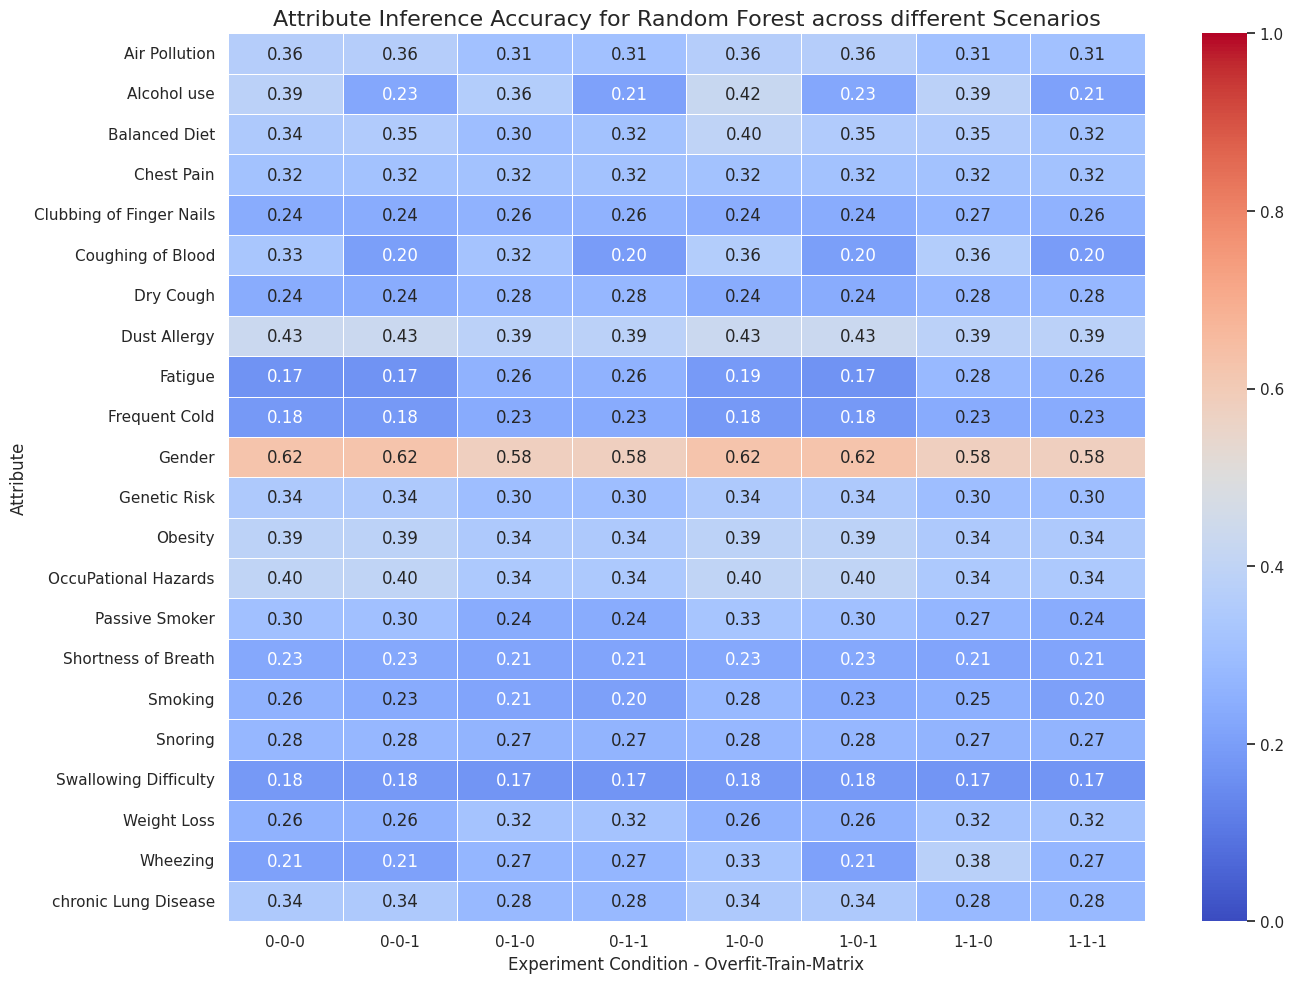

In [85]:
df_rf = pd.read_csv("./results/df_RF.csv")
evaluation_heatmap(df_rf, 'Random Forest')

# Multilayer Perceptron Model

For the Neural Network model we create and use two different models:
- `model_perfectFit` which acheives a perfect accuracy score on both train and test set
- `model_underFit` this model includes restrictions on number of layers and nodes, limiting the model's ability to fit to the trained data

In [ ]:
FEATURES=X_train.columns

In [ ]:
model = make_pipeline(
    StandardScaler(),
    MLPClassifier(alpha=1e-5,random_state=1,max_iter=500)
)

In [ ]:
col_num=["Age"]
col_cat=["Gender"]
col_ordinal=X_train.columns.drop(["Gender","Age"])

In [ ]:
prep_pipeline = compose.ColumnTransformer(transformers=[
     ('scaler', StandardScaler(), col_num),
     ('ord_encoder', preprocessing.OrdinalEncoder(), col_ordinal),
     ('ohe_encoder', preprocessing.OneHotEncoder(), col_cat)
     ])


In [ ]:
model_perfectFit = make_pipeline(
    prep_pipeline,
    MLPClassifier(random_state=1,max_iter=200,solver="lbfgs",hidden_layer_sizes=(5,7),activation="relu",learning_rate="invscaling")
)

In [ ]:
model_perfectFit

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['Age']),
                                                 ('ord_encoder',
                                                  OrdinalEncoder(),
                                                  Index(['Air Pollution', 'Alcohol use', 'Dust Allergy', 'OccuPational Hazards',
       'Genetic Risk', 'chronic Lung Disease', 'Balanced Diet', 'Obesity',
       'Smoking', 'Passive Smoker', 'Chest Pain', 'Coughing of Blood',
       'Fatigue', 'Weight Loss', 'Shortness of Breath', 'Wheezing',
       'Swallowing Difficulty', 'Clubbing of Finger Nails', 'Frequent Cold',
       'Dry Cough', 'Snoring'],
      dtype='object')),
                                                 ('ohe_encoder',
                                                  OneHotEncoder(),
                                                  ['Gender'])])),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=(5, 7),
                               learning_rate='invscaling', random_state=1,
                               solver='lbfgs'))])

In [ ]:
model_perfectFit=model_perfectFit.fit(X_train, y_train)

In [ ]:
model_underFit = make_pipeline(
    prep_pipeline,
    MLPClassifier(random_state=1,max_iter=200,solver="lbfgs",hidden_layer_sizes=(3,3),activation="relu",learning_rate="invscaling")
)

In [ ]:
model_underFit=model_underFit.fit(X_train, y_train)

## Performance

Accuracy scores for both models on training set, compared

In [ ]:
print(accuracy_score(y_train,model_perfectFit.predict(X_train)))
print(accuracy_score(y_train,model_underFit.predict(X_train)))

1.0
0.63


Accuracy scores for both models on test set, compared

In [ ]:
print(accuracy_score(y_test,model_perfectFit.predict(X_test)))
print(accuracy_score(y_test,model_underFit.predict(X_test)))

1.0
0.665


The best parameters from grid search: {'mlpclassifier__activation': 'relu',
 'mlpclassifier__alpha': 0.0001,
 'mlpclassifier__hidden_layer_sizes': (7, 5),
 'mlpclassifier__solver': 'lbfgs'} -> but with no convergence

## Experiments

### Overfitting Scenario

Since we achieve accuracy = 100% in training and test set, the attribute with the prediction matrix only considers the priors

In [ ]:
df=pd.DataFrame(columns=['Attr', 'Value','Matrix','Train','Fit'])

In [ ]:
FEATURES = X_train.columns[1:]

#### Single missing feature -  Sample was in training set

In [ ]:

for attr in FEATURES:
  val=run_experiment(model_perfectFit, LABELS, X_train,
                                    X_valid, y_valid, [attr])
  print(f"{attr}", val)
  new_row = pd.Series({'Attr': attr, 'Value': val[0], 'Matrix': 0, 'Train': 1,'Fit':'perfect'})
  df=pd.concat([df, new_row.to_frame().T], ignore_index=True)


Gender [0.58]
Air Pollution [0.31]
Alcohol use [0.34]
Dust Allergy [0.385]
OccuPational Hazards [0.395]
Genetic Risk [0.32]
chronic Lung Disease [0.285]
Balanced Diet [0.43]
Obesity [0.355]
Smoking [0.27]
Passive Smoker [0.33]
Chest Pain [0.325]
Coughing of Blood [0.2]
Fatigue [0.29]
Weight Loss [0.335]
Shortness of Breath [0.24]
Wheezing [0.275]
Swallowing Difficulty [0.23]
Clubbing of Finger Nails [0.305]
Frequent Cold [0.245]
Dry Cough [0.29]
Snoring [0.28]


In [ ]:
pd.DataFrame(df)

,Attr,Value,Matrix,Train,Fit
0,Gender,0.58,0,1,perfect
1,Air Pollution,0.31,0,1,perfect
2,Alcohol use,0.34,0,1,perfect
3,Dust Allergy,0.385,0,1,perfect
4,OccuPational Hazards,0.395,0,1,perfect
5,Genetic Risk,0.32,0,1,perfect
6,chronic Lung Disease,0.285,0,1,perfect
7,Balanced Diet,0.43,0,1,perfect
8,Obesity,0.355,0,1,perfect
9,Smoking,0.27,0,1,perfect


In [ ]:
y_pred_perfect=model_perfectFit.predict(X_train)

In [ ]:
LABELS.keys

<function dict.keys>

In [ ]:
matrix_perfect= confusion_matrix(y_train, y_pred_perfect,normalize="pred", labels=list(LABELS.keys()))

In [ ]:

for attr in FEATURES:
  val=run_experiment(model_perfectFit, LABELS, X_train,
                                    X_valid, y_valid, [attr],conf_matrix=matrix_perfect)
  print(f"{attr}", val)
  new_row = pd.Series({'Attr': attr, 'Value': val[0], 'Matrix': 1, 'Train': 1,'Fit':'perfect'})
  df=pd.concat([df, new_row.to_frame().T], ignore_index=True)

Gender [0.58]
Air Pollution [0.31]
Alcohol use [0.315]
Dust Allergy [0.385]
OccuPational Hazards [0.395]
Genetic Risk [0.32]
chronic Lung Disease [0.285]
Balanced Diet [0.43]
Obesity [0.35]
Smoking [0.27]
Passive Smoker [0.33]
Chest Pain [0.325]
Coughing of Blood [0.2]
Fatigue [0.275]
Weight Loss [0.335]
Shortness of Breath [0.24]
Wheezing [0.275]
Swallowing Difficulty [0.23]
Clubbing of Finger Nails [0.305]
Frequent Cold [0.245]
Dry Cough [0.29]
Snoring [0.28]


#### Single missing feature -  Sample was not in training set

In [ ]:
for attr in FEATURES:
  val=run_experiment(model_perfectFit, LABELS, X_train,
                                    X_test, y_test, [attr])
  print(f"{attr}", val)
  new_row = pd.Series({'Attr': attr, 'Value': val[0], 'Matrix': 0, 'Train': 0,'Fit':'perfect'})
  df=pd.concat([df, new_row.to_frame().T], ignore_index=True)

Gender [0.625]
Air Pollution [0.365]
Alcohol use [0.335]
Dust Allergy [0.43]
OccuPational Hazards [0.445]
Genetic Risk [0.355]
chronic Lung Disease [0.345]
Balanced Diet [0.425]
Obesity [0.41]
Smoking [0.28]
Passive Smoker [0.39]
Chest Pain [0.335]
Coughing of Blood [0.22]
Fatigue [0.2]
Weight Loss [0.265]
Shortness of Breath [0.24]
Wheezing [0.23]
Swallowing Difficulty [0.23]
Clubbing of Finger Nails [0.28]
Frequent Cold [0.195]
Dry Cough [0.27]
Snoring [0.295]


In [ ]:
for attr in FEATURES:
  val=run_experiment(model_perfectFit, LABELS, X_train,
                                    X_test, y_test, [attr],conf_matrix=matrix_perfect)
  print(f"{attr}", val)
  new_row = pd.Series({'Attr': attr, 'Value': val[0], 'Matrix': 1, 'Train': 0,'Fit':'perfect'})
  df=pd.concat([df, new_row.to_frame().T], ignore_index=True)

Gender [0.625]
Air Pollution [0.365]
Alcohol use [0.33]
Dust Allergy [0.43]
OccuPational Hazards [0.445]
Genetic Risk [0.355]
chronic Lung Disease [0.345]
Balanced Diet [0.425]
Obesity [0.41]
Smoking [0.28]
Passive Smoker [0.39]
Chest Pain [0.335]
Coughing of Blood [0.22]
Fatigue [0.19]
Weight Loss [0.265]
Shortness of Breath [0.24]
Wheezing [0.23]
Swallowing Difficulty [0.23]
Clubbing of Finger Nails [0.28]
Frequent Cold [0.195]
Dry Cough [0.27]
Snoring [0.295]


### Reducing Overfitting Scenario

In [ ]:
y_pred_under=model_underFit.predict(X_train)

In [ ]:
matrix_underFit= confusion_matrix(y_train, y_pred_under,normalize="pred", labels=list(LABELS.keys()))

#### Single missing feature -  Sample was in training set

In [ ]:

for attr in FEATURES:
  val=run_experiment(model_underFit, LABELS, X_train,
                                    X_valid, y_valid, [attr])
  print(f"{attr}", val)
  new_row = pd.Series({'Attr': attr, 'Value': val[0], 'Matrix': 0, 'Train': 1,'Fit':'under'})
  df=pd.concat([df, new_row.to_frame().T], ignore_index=True)

Gender [0.59]
Air Pollution [0.39]
Alcohol use [0.385]
Dust Allergy [0.385]
OccuPational Hazards [0.34]
Genetic Risk [0.355]
chronic Lung Disease [0.35]
Balanced Diet [0.325]
Obesity [0.37]
Smoking [0.175]
Passive Smoker [0.23]
Chest Pain [0.35]
Coughing of Blood [0.305]
Fatigue [0.265]
Weight Loss [0.32]
Shortness of Breath [0.215]
Wheezing [0.3]
Swallowing Difficulty [0.275]
Clubbing of Finger Nails [0.265]
Frequent Cold [0.245]
Dry Cough [0.29]
Snoring [0.265]


In [ ]:
for attr in FEATURES:
  val=run_experiment(model_perfectFit, LABELS, X_train,
                                    X_valid, y_valid, [attr],conf_matrix=matrix_underFit)
  print(f"{attr}", val)
  new_row = pd.Series({'Attr': attr, 'Value': val[0], 'Matrix': 1, 'Train': 1,'Fit':'under'})
  df=pd.concat([df, new_row.to_frame().T], ignore_index=True)

Gender [0.58]
Air Pollution [0.31]
Alcohol use [0.315]
Dust Allergy [0.385]
OccuPational Hazards [0.395]
Genetic Risk [0.32]
chronic Lung Disease [0.285]
Balanced Diet [0.43]
Obesity [0.35]
Smoking [0.27]
Passive Smoker [0.33]
Chest Pain [0.325]
Coughing of Blood [0.2]
Fatigue [0.275]
Weight Loss [0.335]
Shortness of Breath [0.24]
Wheezing [0.275]
Swallowing Difficulty [0.23]
Clubbing of Finger Nails [0.305]
Frequent Cold [0.245]
Dry Cough [0.29]
Snoring [0.27]


####Single missing feature -  Sample was not in training set

In [ ]:
for attr in FEATURES:
  val= run_experiment(model_underFit, LABELS, X_train,
                                    X_test, y_test, [attr])
  print(f"{attr}", val)
  new_row = pd.Series({'Attr': attr, 'Value': val[0], 'Matrix': 0, 'Train': 0,'Fit':'under'})
  df=pd.concat([df, new_row.to_frame().T], ignore_index=True)

Gender [0.595]
Air Pollution [0.435]
Alcohol use [0.43]
Dust Allergy [0.43]
OccuPational Hazards [0.4]
Genetic Risk [0.375]
chronic Lung Disease [0.415]
Balanced Diet [0.39]
Obesity [0.41]
Smoking [0.2]
Passive Smoker [0.315]
Chest Pain [0.355]
Coughing of Blood [0.33]
Fatigue [0.2]
Weight Loss [0.26]
Shortness of Breath [0.23]
Wheezing [0.255]
Swallowing Difficulty [0.32]
Clubbing of Finger Nails [0.245]
Frequent Cold [0.22]
Dry Cough [0.255]
Snoring [0.32]


In [ ]:
for attr in FEATURES:
  val=  run_experiment(model_perfectFit, LABELS, X_train,
                                    X_test, y_test, [attr],conf_matrix=matrix_underFit)
  print(f"{attr}", val)
  new_row = pd.Series({'Attr': attr, 'Value': val[0], 'Matrix': 1, 'Train': 0,'Fit':'under'})
  df=pd.concat([df, new_row.to_frame().T], ignore_index=True)

Gender [0.625]
Air Pollution [0.365]
Alcohol use [0.33]
Dust Allergy [0.43]
OccuPational Hazards [0.445]
Genetic Risk [0.355]
chronic Lung Disease [0.345]
Balanced Diet [0.425]
Obesity [0.41]
Smoking [0.28]
Passive Smoker [0.39]
Chest Pain [0.335]
Coughing of Blood [0.22]
Fatigue [0.19]
Weight Loss [0.265]
Shortness of Breath [0.24]
Wheezing [0.23]
Swallowing Difficulty [0.23]
Clubbing of Finger Nails [0.28]
Frequent Cold [0.195]
Dry Cough [0.27]
Snoring [0.285]


In [ ]:
df

,Attr,Value,Matrix,Train,Fit
0,Gender,0.58,0,1,perfect
1,Air Pollution,0.31,0,1,perfect
2,Alcohol use,0.34,0,1,perfect
3,Dust Allergy,0.385,0,1,perfect
4,OccuPational Hazards,0.395,0,1,perfect
...,...,...,...,...,...
171,Swallowing Difficulty,0.23,1,0,under
172,Clubbing of Finger Nails,0.28,1,0,under
173,Frequent Cold,0.195,1,0,under
174,Dry Cough,0.27,1,0,under


In [ ]:
df["Model"]="NN"

In [ ]:
df.to_csv("./results/df_NN.csv")

### Evaluation

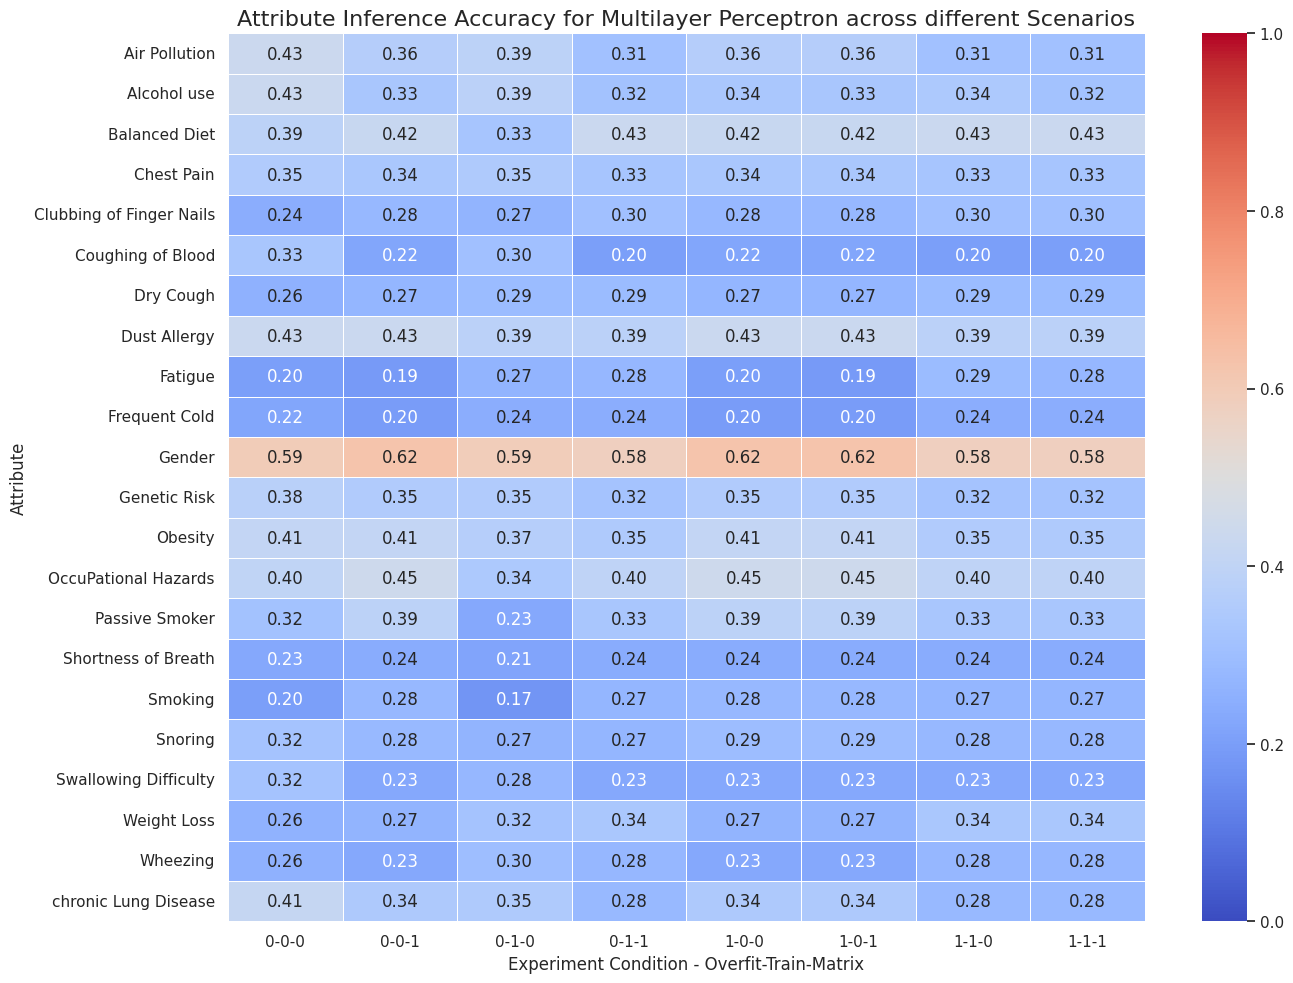

In [ ]:
df_nn = pd.read_csv("./results/df_NN.csv")

evaluation_heatmap(df_nn, 'Multilayer Perceptron')